In [114]:
import pandas
import numpy as np
from collections import Counter
from collections import defaultdict
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pandas.read_csv('/home/tylorn/train2.csv')
test = pandas.read_csv('/home/tylorn/test2.csv')

In [81]:
team_universe = set(train.team1) | set(train.team2) | set(test.team2) | set(test.team1)

In [82]:
TEAM_SIZE = max(team_universe) + 1

In [4]:
train.year.unique()

array([2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008,
       3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019])

In [5]:
test.year.unique()

array([3021, 3020])

In [8]:
len(train.team1.unique()), len(test.team1.unique())

(353, 350)

In [9]:
len(train.team2.unique()), len(test.team2.unique())

(353, 350)

In [10]:
len(set(zip(train.team1, train.team2)))

26874

In [16]:
train['pair'] = zip(train.team1, train.team2)

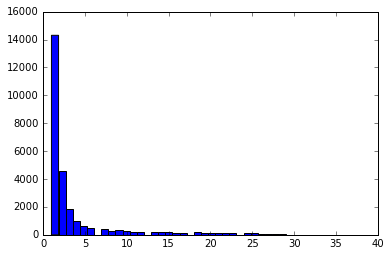

In [21]:
plt.hist(Counter(train.pair).values(), bins=40)
plt.show()

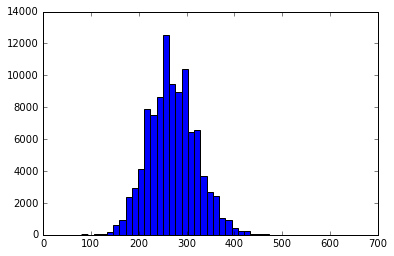

In [22]:
plt.hist(train.score1, bins=40)
plt.show()

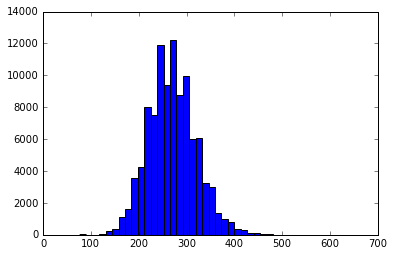

In [23]:
plt.hist(train.score2, bins=40)
plt.show()

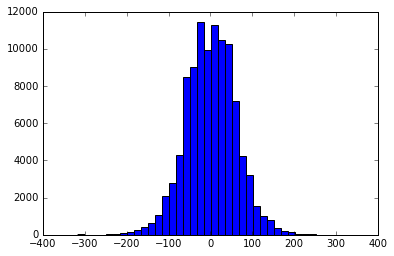

In [24]:
plt.hist(train.score1 - train.score2, bins=40)
plt.show()

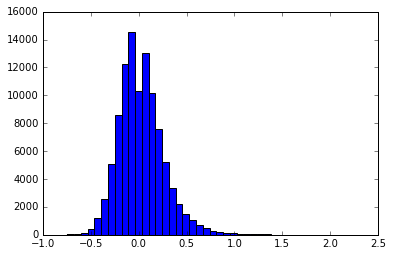

In [35]:
plt.hist((train.score1 - train.score2) / train.score2, bins=40)
plt.show()

In [26]:
train['year_pair'] = zip(train.team1, train.team2, train.year)

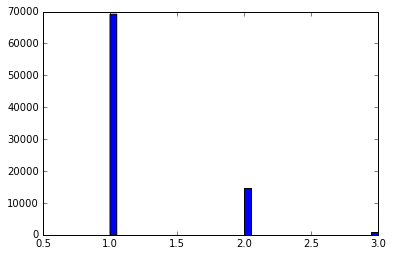

In [27]:
plt.hist(Counter(train.year_pair).values(), bins=40)
plt.show()

In [57]:
true_train = train[train.year < 3016]

In [58]:
validate_train = train[train.year >= 3016]

In [36]:
train.score1.mean()

270.28140223799073

In [37]:
train.target.mean()

0.50096940231672393

In [ ]:
class FeatureExtractor_Backup1(object):
    def __init__(self, shift):
        self.shift = shift
        self.pairs_history = defaultdict(lambda: defaultdict(list))
        self.team_history = defaultdict(lambda: defaultdict(list))
        
    def add_2_history(self, game):
        self.pairs_history[(game.team1, game.team2)][game.year].append({
            'target': int(game.target),
            'score_tuple': (game.score1, game.score2)
        })
        self.pairs_history[(game.team2, game.team1)][game.year].append({
            'target': 1 - int(game.target),
            'score_tuple': (game.score2, game.score1)
        })
        self.team_history[game.team1][game.year].append({
            'score': game.score1,
            'target': int(game.target)
        })
        self.team_history[game.team2][game.year].append({
            'score': game.score2,
            'target': 1 - int(game.target)
        })
        
    def get_team_last_games(self, team, years):
        team_history = self.team_history[team]
        for year in years:
            for game in team_history[year]:
                yield game
                
    def get_pair_last_games(self, pair, years):
        team_history = self.pairs_history[pair]
        for year in years:
            for game in team_history[year]:
                yield game
                
    def score_mean(self, scores):
        return (sum(scores) + 27.) / (len(scores) + 0.1)
    
    def target_mean(self, targets):
        return (sum(targets) + 0.05) / (len(targets) + 0.1)
        
    def extract(self, game):
        features = []
        # team features
        # team1
        last_year_games = list(self.get_team_last_games(game.team1, [game.year - i - self.shift for i in xrange(1)]))
        # 0 - number of games last year
        features.append(len(last_year_games))
        # 1 - mean target for last year
        features.append(self.target_mean([x['target'] for x in last_year_games]))
        # 2 - mean score for last year
        team1_mean_score_1_years = self.score_mean([x['score'] for x in last_year_games])
        features.append(team1_mean_score_1_years)
        
        last5_year_games = list(self.get_team_last_games(game.team1, [game.year - i - self.shift for i in xrange(5)]))
        # 3 - number of games last 5 year
        features.append(len(last5_year_games))
        # 4 - mean target for last 5 year
        features.append(self.target_mean([x['target'] for x in last5_year_games]))
        # 5 - mean score for last 5 year
        team1_mean_score_5_years = self.score_mean([x['score'] for x in last5_year_games])
        features.append(team1_mean_score_5_years)
        
        # team2
        last_year_games = list(self.get_team_last_games(game.team2, [game.year - i - self.shift for i in xrange(1)]))
        # 6 - number of games last year
        features.append(len(last_year_games))
        # 7 - mean target for last year
        features.append(self.target_mean([x['target'] for x in last_year_games]))
        # 8 - mean score for last year
        team2_mean_score_1_years = self.score_mean([x['score'] for x in last_year_games])
        features.append(team2_mean_score_1_years)
        
        last5_year_games = list(self.get_team_last_games(game.team2, [game.year - i - self.shift for i in xrange(5)]))
        # 9 - number of games last 5 year
        features.append(len(last5_year_games))
        # 10 - mean target for last 5 year
        features.append(self.target_mean([x['target'] for x in last5_year_games]))
        # 11 - mean score for last 5 year
        team2_mean_score_5_years = self.score_mean([x['score'] for x in last5_year_games])
        features.append(team2_mean_score_5_years)
        
        # compare means
        # 12 compare mean_score_1_years
        features.append(team1_mean_score_1_years - team2_mean_score_1_years)
        # 13 compare mean_score_5_years
        features.append(team1_mean_score_5_years - team2_mean_score_5_years)
        
        #pair
        last_year_games = list(self.get_pair_last_games((game.team1, game.team2), [game.year - i - self.shift for i in xrange(1)]))
        # 14 - number of games last year
        features.append(len(last_year_games))
        # 15 - mean target for last year
        features.append(self.target_mean([x['target'] for x in last_year_games]))
        
        last5_year_games = list(self.get_pair_last_games((game.team1, game.team2), [game.year - i - self.shift for i in xrange(5)]))
        # 16 - number of games last year
        features.append(len(last5_year_games))
        # 17 - mean target for last year
        features.append(self.target_mean([x['target'] for x in last5_year_games]))
        
        return features


In [133]:
class FeatureExtractor(object):
    def __calc_prob(self, year):
        self.first_win_prob = self.first_win_count / self.matches_count
        cum_prob1 = np.dot(np.linalg.inv(np.identity(TEAM_SIZE) - 0.005 * self.first_win_prob), self.first_win_prob)
        cum_prob2 = np.dot(np.linalg.inv(np.identity(TEAM_SIZE) - 0.0025 * self.first_win_prob), self.first_win_prob)
        cum_prob3 = np.dot(np.linalg.inv(np.identity(TEAM_SIZE) - 0.001 * self.first_win_prob), self.first_win_prob)
        
        cum_prob4 = np.dot(self.first_win_prob, self.first_win_prob)
        cum_prob5 = np.dot(self.first_win_prob, self.first_win_prob) + self.first_win_prob
        cum_prob6 = np.dot(self.first_win_prob, self.first_win_prob) + 10 * self.first_win_prob
        
        self.cum_prob1[year] = cum_prob1 / (cum_prob1 + np.transpose(cum_prob1))
        self.cum_prob2[year] = cum_prob2 / (cum_prob2 + np.transpose(cum_prob2))
        self.cum_prob3[year] = cum_prob3 / (cum_prob3 + np.transpose(cum_prob3))
        
        self.cum_prob4[year] = cum_prob4 / (cum_prob4 + np.transpose(cum_prob4))
        self.cum_prob5[year] = cum_prob5 / (cum_prob5 + np.transpose(cum_prob5))
        self.cum_prob6[year] = cum_prob6 / (cum_prob6 + np.transpose(cum_prob6))
    
    def __init__(self, shift):
        self.shift = shift
        self.pairs_history = defaultdict(lambda: defaultdict(list))
        self.team_history = defaultdict(lambda: defaultdict(list))
        self.matches_count = np.zeros(shape=(TEAM_SIZE, TEAM_SIZE)) + 1
        self.first_win_count = np.zeros(shape=(TEAM_SIZE, TEAM_SIZE)) + 0.5
        
        self.cum_prob1 = {}
        self.cum_prob2 = {}
        self.cum_prob3 = {}
        self.cum_prob4 = {}
        self.cum_prob5 = {}
        self.cum_prob6 = {}
        
        self.__calc_prob(0)
        

    def push_year(self, year):
        for pair, events in self.pairs_history[year].iteritems():
            self.matches_count[pair[0], pair[1]] += 0.5 * len(events)
            self.first_win_count[pair[0], pair[1]] += 1 * sum([x['target'] for x in events])
        self.__calc_prob(year)
        
        
    def add_2_history(self, game):
        self.pairs_history[game.year][(game.team1, game.team2)].append({
            'target': int(game.target),
            'score_tuple': (game.score1, game.score2)
        })
        self.pairs_history[game.year][(game.team2, game.team1)].append({
            'target': 1 - int(game.target),
            'score_tuple': (game.score2, game.score1)
        })
        self.team_history[game.team1][game.year].append({
            'score': game.score1,
            'score_diff': game.score1 - game.score2,
            'target': int(game.target)
        })
        self.team_history[game.team2][game.year].append({
            'score': game.score2,
            'score_diff': game.score2 - game.score1,
            'target': 1 - int(game.target)
        })
        
    def get_team_last_games(self, team, years):
        team_history = self.team_history[team]
        for year in years:
            for game in team_history[year]:
                yield game
                
    def get_pair_last_games(self, pair, years):
        for year in years:
            for game in self.pairs_history[year][pair]:
                yield game
                
    def score_mean(self, scores):
        return (sum(scores) + 27.) / (len(scores) + 0.1)
    
    def target_mean(self, targets):
        return (sum(targets) + 0.05) / (len(targets) + 0.1)
    
    def diff_mean(self, targets):
        return (sum(targets) + 0.) / (len(targets) + 0.1)
        
    def extract(self, game):
        features = []
        # team features
        # team1
        last_year_games = list(self.get_team_last_games(game.team1, [game.year - i - self.shift for i in xrange(1)]))
        # 0 - number of games last year
        features.append(len(last_year_games))
        # 1 - mean target for last year
        features.append(self.target_mean([x['target'] for x in last_year_games]))
        # 2 - mean score_diff for last year
        features.append(self.diff_mean([x['score_diff'] for x in last_year_games]))
        # 3 - mean score for last year
        team1_mean_score_1_years = self.score_mean([x['score'] for x in last_year_games])
        features.append(team1_mean_score_1_years)
        
        last2_year_games = list(self.get_team_last_games(game.team1, [game.year - i - self.shift for i in xrange(2)]))
        # 4 - number of games last 2 year
        features.append(len(last2_year_games))
        # 5 - mean target for last 2 year
        features.append(self.target_mean([x['target'] for x in last2_year_games]))
        # 6 - mean score_diff for last 2 year
        features.append(self.diff_mean([x['score_diff'] for x in last2_year_games]))
        # 7 - mean score for last 2 year
        team1_mean_score_2_years = self.score_mean([x['score'] for x in last2_year_games])
        features.append(team1_mean_score_2_years)
        
        last5_year_games = list(self.get_team_last_games(game.team1, [game.year - i - self.shift for i in xrange(5)]))
        # 8 - number of games last 5 year
        features.append(len(last5_year_games))
        # 9 - mean target for last 5 year
        features.append(self.target_mean([x['target'] for x in last5_year_games]))
        # 10 - mean score for last 5 year
        team1_mean_score_5_years = self.score_mean([x['score'] for x in last5_year_games])
        features.append(team1_mean_score_5_years)
        
        # team2
        last_year_games = list(self.get_team_last_games(game.team2, [game.year - i - self.shift for i in xrange(1)]))
        # 11 - number of games last year
        features.append(len(last_year_games))
        # 12 - mean target for last year
        features.append(self.target_mean([x['target'] for x in last_year_games]))
        # 13 - mean score_diff for last 2 year
        features.append(self.diff_mean([x['score_diff'] for x in last_year_games]))
        # 14 - mean score for last year
        team2_mean_score_1_years = self.score_mean([x['score'] for x in last_year_games])
        features.append(team2_mean_score_1_years)
        
        last_year2_games = list(self.get_team_last_games(game.team2, [game.year - i - self.shift for i in xrange(2)]))
        # 15 - number of games last 2 year
        features.append(len(last2_year_games))
        # 16 - mean target for last 2 year
        features.append(self.target_mean([x['target'] for x in last2_year_games]))
        # 17 - mean score_diff for last 2 year
        features.append(self.diff_mean([x['score_diff'] for x in last2_year_games]))
        # 18 - mean score for last 2 year
        team2_mean_score_2_years = self.score_mean([x['score'] for x in last2_year_games])
        features.append(team2_mean_score_2_years)
        
        last5_year_games = list(self.get_team_last_games(game.team2, [game.year - i - self.shift for i in xrange(5)]))
        # 19 - number of games last 5 year
        features.append(len(last5_year_games))
        # 20 - mean target for last 5 year
        features.append(self.target_mean([x['target'] for x in last5_year_games]))
        # 21 - mean score for last 5 year
        team2_mean_score_5_years = self.score_mean([x['score'] for x in last5_year_games])
        features.append(team2_mean_score_5_years)
        
        # compare means
        # 22 compare mean_score_1_years
        features.append(team1_mean_score_1_years - team2_mean_score_1_years)
        # 23 compare mean_score_2_years
        features.append(team1_mean_score_2_years - team2_mean_score_2_years)
        # 24 compare mean_score_5_years
        features.append(team1_mean_score_5_years - team2_mean_score_5_years)
        
        #pair
        last_year_games = list(self.get_pair_last_games((game.team1, game.team2), [game.year - i - self.shift for i in xrange(1)]))
        # 25 - number of games last year
        features.append(len(last_year_games))
        # 26 - mean target for last year
        features.append(self.target_mean([x['target'] for x in last_year_games]))
        
        last2_year_games = list(self.get_pair_last_games((game.team1, game.team2), [game.year - i - self.shift for i in xrange(2)]))
        # 27 - number of games last 2 year
        features.append(len(last2_year_games))
        # 28 - mean target for last 2 year
        features.append(self.target_mean([x['target'] for x in last2_year_games]))
        
        last5_year_games = list(self.get_pair_last_games((game.team1, game.team2), [game.year - i - self.shift for i in xrange(5)]))
        # 29 - number of games last 5 year
        features.append(len(last5_year_games))
        # 30 - mean target for last 5 year
        features.append(self.target_mean([x['target'] for x in last5_year_games]))
        
        #cum prob
        # 31 - cumprob1
        features.append(self.cum_prob1[game.year - self.shift][game.team1, game.team2])
        # 32 - cumprob2
        features.append(self.cum_prob2[game.year - self.shift][game.team1, game.team2])
        # 33 - cumprob3
        features.append(self.cum_prob3[game.year - self.shift][game.team1, game.team2])
        
        # 34 - cumprob4
        features.append(self.cum_prob4[game.year - self.shift][game.team1, game.team2])
        # 35 - cumprob5
        features.append(self.cum_prob5[game.year - self.shift][game.team1, game.team2])
        # 36 - cumprob6
        features.append(self.cum_prob6[game.year - self.shift][game.team1, game.team2])
        
        #cum prob
        # 37 - cumprob1 5 years old
        features.append(self.cum_prob1[game.year - self.shift - 4][game.team1, game.team2])
        # 38 - cumprob2 5 years old
        features.append(self.cum_prob2[game.year - self.shift - 4][game.team1, game.team2])
        # 39 - cumprob3 5 years old
        features.append(self.cum_prob3[game.year - self.shift - 4][game.team1, game.team2])
        
        # 40 - cumprob4 5 years old
        features.append(self.cum_prob4[game.year - self.shift - 4][game.team1, game.team2])
        # 41 - cumprob5 5 years old
        features.append(self.cum_prob5[game.year - self.shift - 4][game.team1, game.team2])
        # 42 - cumprob6 5 years old
        features.append(self.cum_prob6[game.year - self.shift - 4][game.team1, game.team2])
        
        return features


In [140]:
feature_extractor1 = FeatureExtractor(1)
feature_extractor2 = FeatureExtractor(2)

In [141]:
not_pushed_years = deque([0])
with open('/home/tylorn/m_train_train', 'w') as f:
    for index, game in true_train.sort_values(by='year').iterrows():
        if game.year != not_pushed_years[-1]:
            if len(not_pushed_years) == 1:
                feature_extractor1.push_year(not_pushed_years[0])
                not_pushed_years.popleft()
            not_pushed_years.append(game.year)
        if game.year >= 3003:
            features = feature_extractor1.extract(game)
            f.write('\t'.join(map(str, [index, int(game.target), 0, 0] + features)) + '\n')
        feature_extractor1.add_2_history(game)
        
with open('/home/tylorn/m_train_test', 'w') as f:
    for index, game in validate_train.sort_values(by='year').iterrows():
        if game.year != not_pushed_years[-1]:
            if len(not_pushed_years) == 1:
                feature_extractor1.push_year(not_pushed_years[0])
                not_pushed_years.popleft()
            not_pushed_years.append(game.year)
        features = feature_extractor1.extract(game)
        f.write('\t'.join(map(str, [index, int(game.target), 0, 0] + features)) + '\n')
        feature_extractor1.add_2_history(game)

In [142]:
not_pushed_years = deque([0])
with open('/home/tylorn/m_train_train2', 'w') as f:
    for index, game in true_train.sort_values(by='year').iterrows():
        if game.year != not_pushed_years[-1]:
            if len(not_pushed_years) == 2:
                feature_extractor2.push_year(not_pushed_years[0])
                not_pushed_years.popleft()
            not_pushed_years.append(game.year)
        if game.year >= 3004:
            features = feature_extractor2.extract(game)
            f.write('\t'.join(map(str, [index, int(game.target), 0, 0] + features)) + '\n')
        feature_extractor2.add_2_history(game)
        
with open('/home/tylorn/m_train_test2', 'w') as f:
    for index, game in validate_train.sort_values(by='year').iterrows():
        if game.year != not_pushed_years[-1]:
            if len(not_pushed_years) == 2:
                feature_extractor2.push_year(not_pushed_years[0])
                not_pushed_years.popleft()
            not_pushed_years.append(game.year)
        features = feature_extractor2.extract(game)
        f.write('\t'.join(map(str, [index, int(game.target), 0, 0] + features)) + '\n')
        feature_extractor2.add_2_history(game)

In [143]:
feature_extractor1 = FeatureExtractor(1)
feature_extractor2 = FeatureExtractor(2)

not_pushed_years = deque([0])
with open('/home/tylorn/m_train1', 'w') as f:
    for index, game in train.sort_values(by='year').iterrows():
        if game.year != not_pushed_years[-1]:
            if len(not_pushed_years) == 1:
                feature_extractor1.push_year(not_pushed_years[0])
                not_pushed_years.popleft()
            not_pushed_years.append(game.year)
        if game.year >= 3003:
            features = feature_extractor1.extract(game)
            f.write('\t'.join(map(str, [index, int(game.target), 0, 0] + features)) + '\n')
        feature_extractor1.add_2_history(game)

for year in not_pushed_years:
    feature_extractor1.push_year(year)


not_pushed_years = deque([0])
with open('/home/tylorn/m_train2', 'w') as f:
    for index, game in train.sort_values(by='year').iterrows():
        if game.year != not_pushed_years[-1]:
            if len(not_pushed_years) == 2:
                feature_extractor2.push_year(not_pushed_years[0])
                not_pushed_years.popleft()
            not_pushed_years.append(game.year)
        if game.year >= 3004:
            features = feature_extractor2.extract(game)
            f.write('\t'.join(map(str, [index, int(game.target), 0, 0] + features)) + '\n')
        feature_extractor2.add_2_history(game)

for year in not_pushed_years:
    feature_extractor2.push_year(year)


with open('/home/tylorn/m_test1', 'w') as f:
    for index, game in test.sort_values(by='year').iterrows():
        if game.year == 3020:
            features = feature_extractor1.extract(game)
            f.write('\t'.join(map(str, [game.Id, 0, 0, 0] + features)) + '\n')
            
with open('/home/tylorn/m_test2', 'w') as f:
    for index, game in test.sort_values(by='year').iterrows():
        if game.year == 3021:
            features = feature_extractor2.extract(game)
            f.write('\t'.join(map(str, [game.Id, 0, 0, 0] + features)) + '\n')


In [144]:
result = dict()
with open('/home/tylorn/m_test1.test.matrixnet', 'r') as f:
    for line in f.xreadlines():
        fields = line.split('\t')
        result[fields[0]] = fields[-2]
with open('/home/tylorn/m_test2.test.matrixnet', 'r') as f:
    for line in f.xreadlines():
        fields = line.split('\t')
        result[fields[0]] = fields[-2]

with open('/home/tylorn/m_result', 'w') as f:
    f.write('Id,target\n')
    for game_id, prob in result.iteritems():
        f.write(game_id + ',' + prob + '\n')